In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from matplotlib.colors import LogNorm
import astropy.units as u
import astropy.constants as c
import glob

In [2]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
# BP Stylization parameters.

In [3]:
base_dir = r'C:\Users\Brock\Documents\Git\Research\CCDs\Sophia_QE\Data'
save_dir = r'C:\Users\Brock\Documents\Git\Research\CCDs\Sophia_QE\Photos'

in_folder = r'\20241024\QE'

#Good, Good, Water, Water warm and cold, Good, warm and test with lamp

science_in_list = glob.glob(base_dir + in_folder + r'\science_*_2.fits')
dark_in_list = glob.glob(base_dir + in_folder + r'\dark_*.fits')
bias_in_list = glob.glob(base_dir + in_folder + r'\bias_*.fits')

bias_in_list.sort()
dark_in_list.sort()
science_in_list.sort()

In [4]:
master_bias = 0

# BP Create master bias.
for file in bias_in_list:
    hdul = fits.open(file)
    hdr = hdul[0].header
    data = hdul[0].data[0]
    
    master_bias += data
    
    hdul.close()
    
master_bias = master_bias / len(bias_in_list)

hdu = fits.PrimaryHDU(data = master_bias, header = hdr)
hdu.writeto(save_dir + r'\master_bias.fits', overwrite = True)

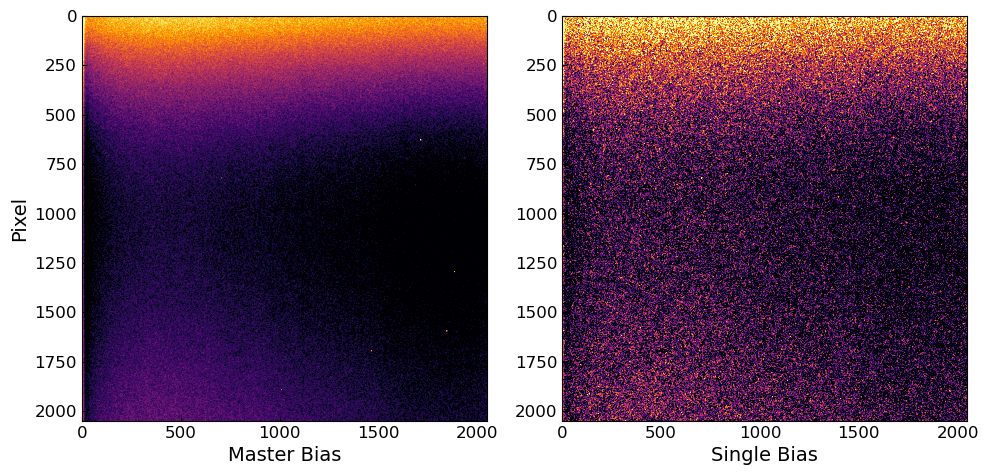

In [17]:
fig, ax = plt.subplots(1,2, layout='tight', figsize=(10,7))
ax[0].imshow(master_bias, vmin=599, vmax=603, cmap='inferno')
cb = ax[1].imshow(data, vmin=599, vmax=603, cmap='inferno')
ax[0].set_xlabel('Master Bias')
ax[1].set_xlabel('Single Bias')
ax[0].set_ylabel(r'Pixel')
ax[0].tick_params(axis='both', direction='in', which='both')
ax[1].tick_params(axis='both', direction='in', which='both')
#plt.colorbar(mappable=cb)
fig.tight_layout()
plt.show()

In [30]:
dark_bias_subtracted_list = []

# BP Subtract master bias from all dark images.
for file in dark_in_list:
    outfile = file.replace('.fits', '_b.fits')
    hdul = fits.open(file)
    hdr = hdul[0].header
    data = hdul[0].data[0]
    
    data = data - master_bias
    
    hdu = fits.PrimaryHDU(data = data, header = hdr)
    hdu.writeto(outfile, overwrite = True)
    
    dark_bias_subtracted_list.append(outfile)
    
    hdul.close()
    
science_bias_subtracted_list = []

# Subtract master bias from all science images.
for file in science_in_list:
    outfile = file.replace('.fits', '_b.fits')
    
    hdul = fits.open(file)
    hdr = hdul[0].header
    data = hdul[0].data[0]
    
    data = data - master_bias
    
    hdu = fits.PrimaryHDU(data = data, header = hdr)
    hdu.writeto(outfile, overwrite = True)
    
    science_bias_subtracted_list.append(outfile)
    
    hdul.close()

In [40]:
master_dark = 0

# BP Create master dark by scaling all darks to 1 second after subtracting bias.
for file in dark_bias_subtracted_list:       
    hdul = fits.open(file)
    hdr = hdul[0].header
    data = hdul[0].data[0]

    exp_time = float(hdr['EXPTIME'])
    
    try:
        scaled_data = data / exp_time
    except:
        print('Temporary issue with dark measurements')
        scaled_data = data
    
    master_dark += scaled_data
    
    hdul.close()
    
master_dark = master_dark / len(dark_bias_subtracted_list)
    
hdu = fits.PrimaryHDU(data = master_dark, header = hdr)
hdu.writeto(save_dir + r'\master_dark.fits', overwrite = True)
# BP Currently generating and using master_dark, may be better to use individual darks for each wavelength, as exposure time should be the same.

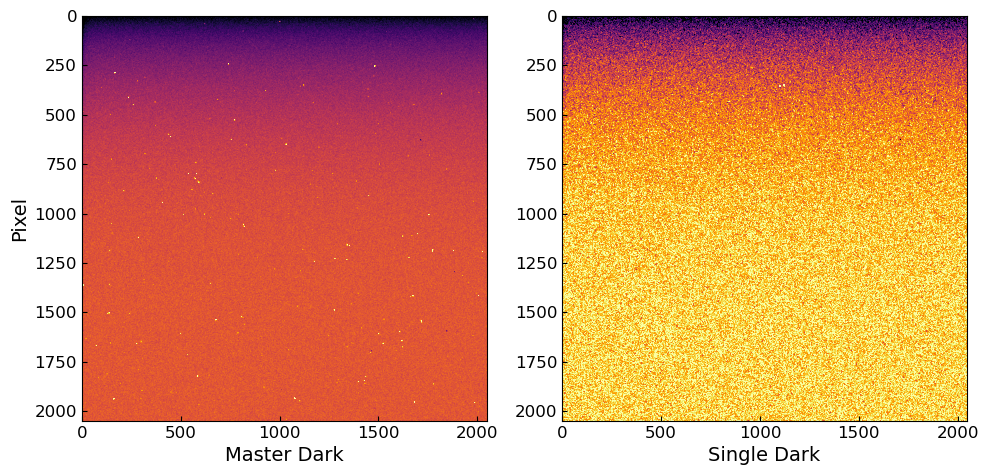

In [48]:
fig, ax = plt.subplots(1,2, layout='tight', figsize=(10,7))
ax[0].imshow(master_dark, vmin=0, vmax=0.0003, cmap='inferno')
cb = ax[1].imshow(data/exp_time, vmin=0, vmax=0.0003, cmap='inferno')
ax[0].set_xlabel('Master Dark')
ax[1].set_xlabel('Single Dark')
ax[0].set_ylabel(r'Pixel')
ax[0].tick_params(axis='both', direction='in', which='both')
ax[1].tick_params(axis='both', direction='in', which='both')
#plt.colorbar(mappable=cb)
fig.tight_layout()
plt.show()

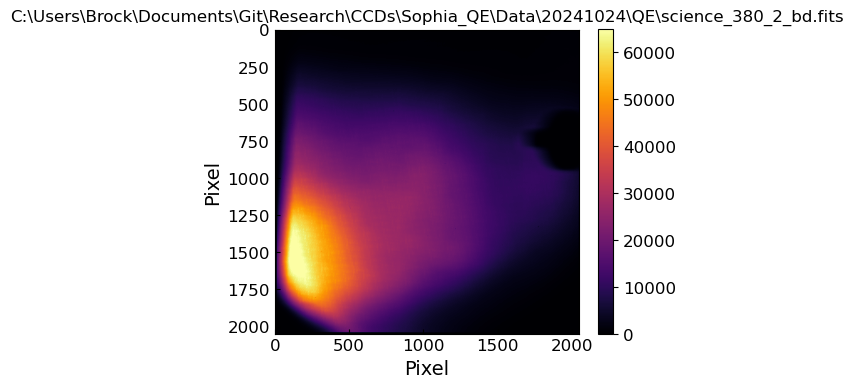

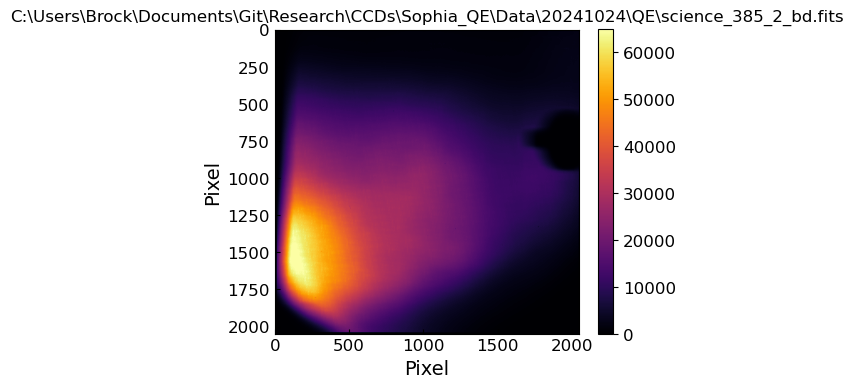

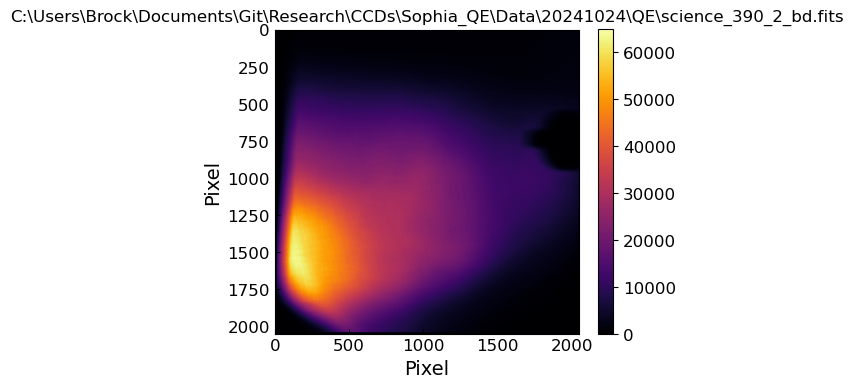

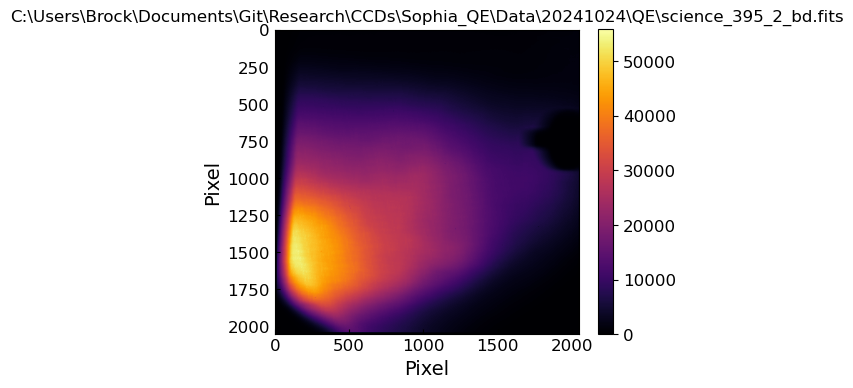

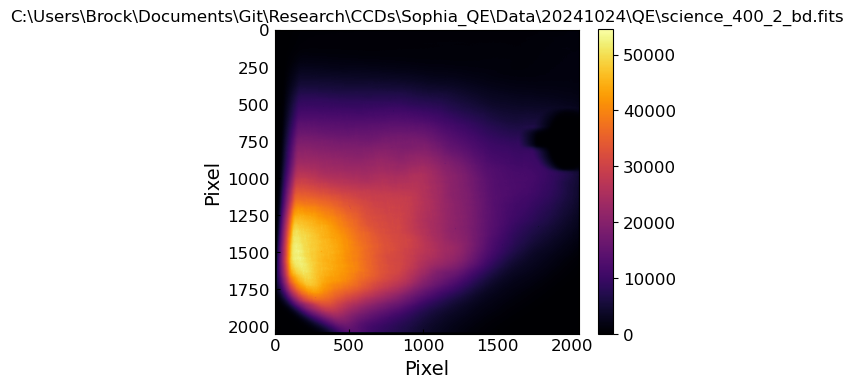

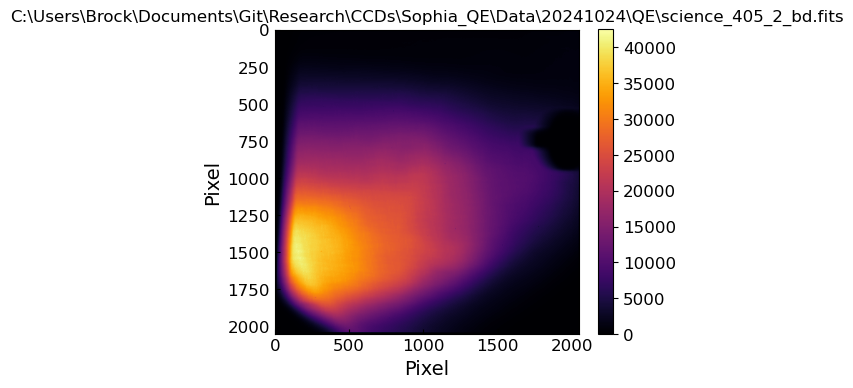

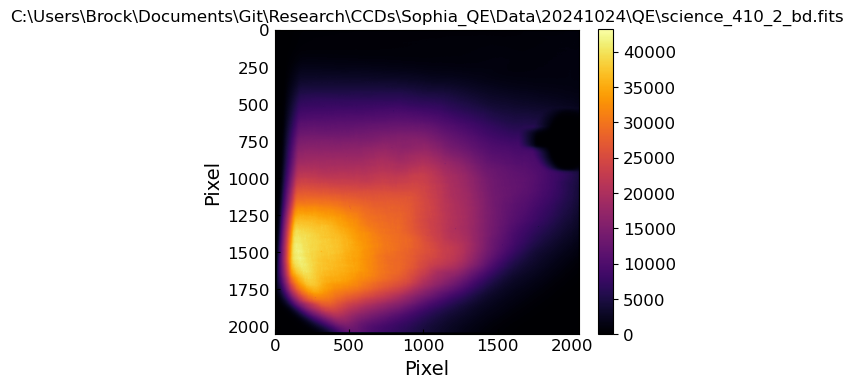

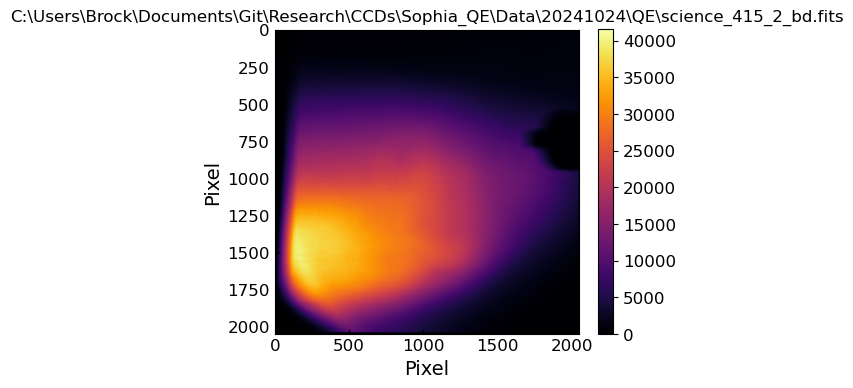

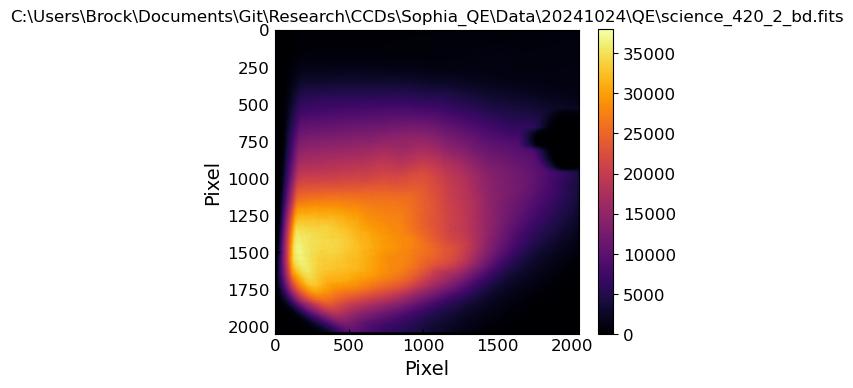

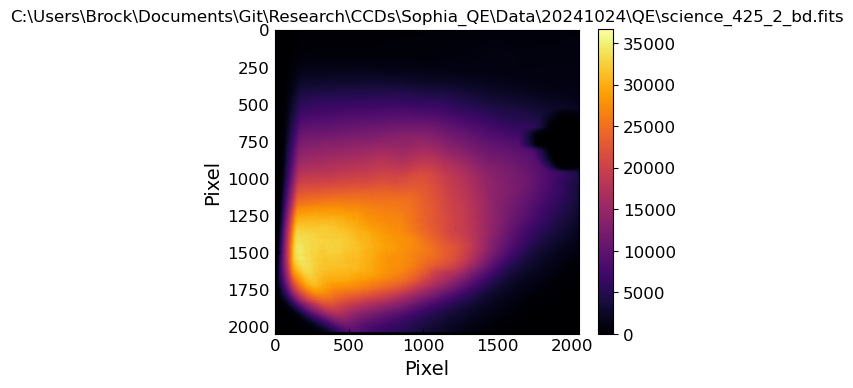

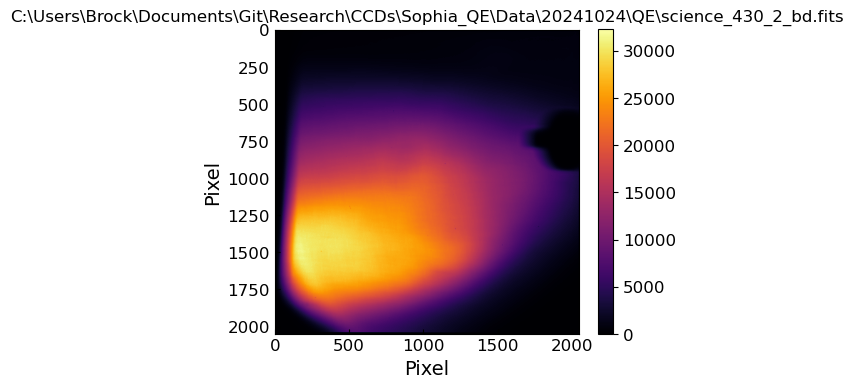

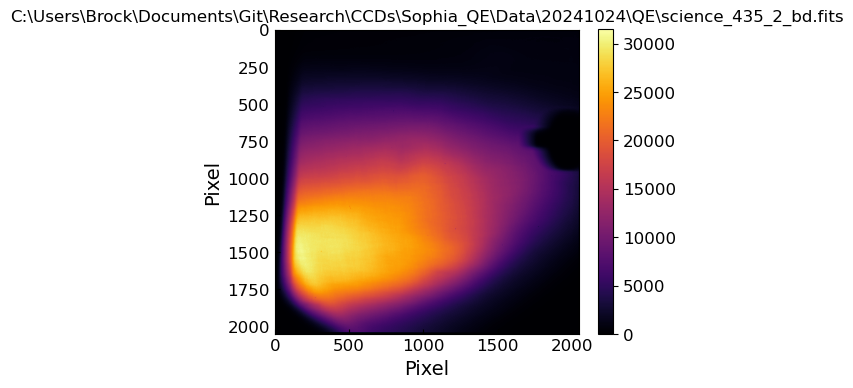

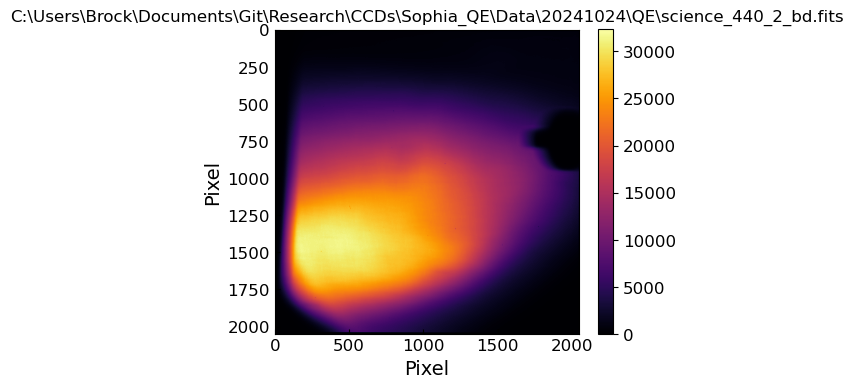

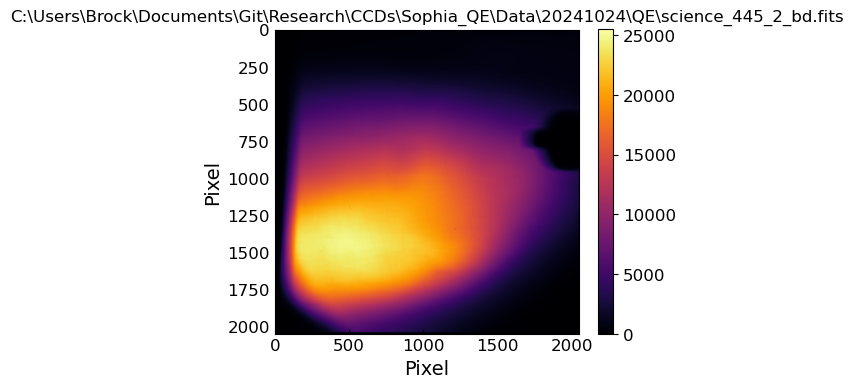

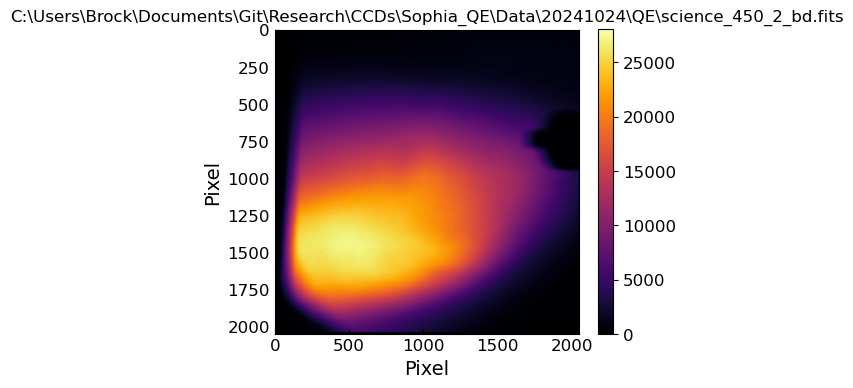

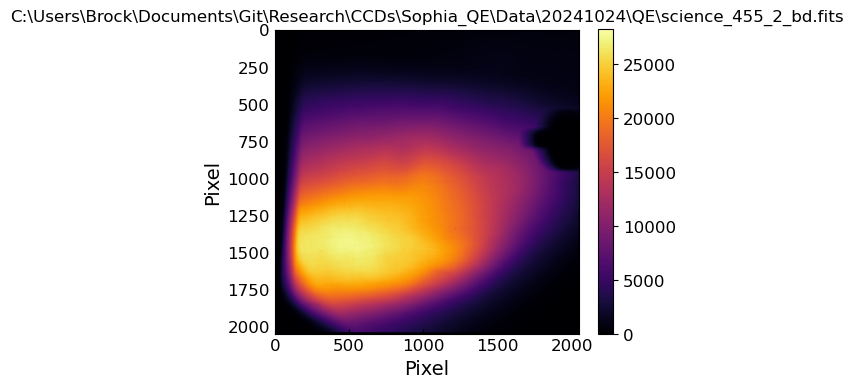

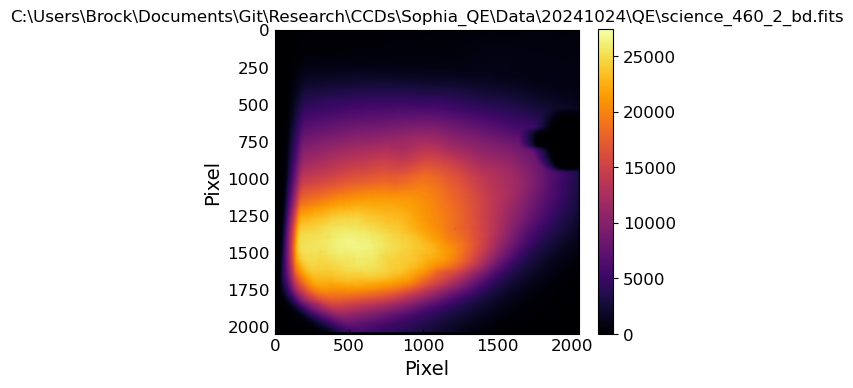

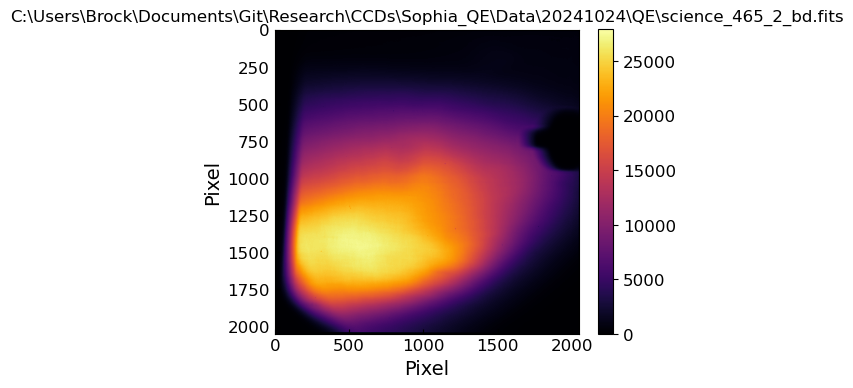

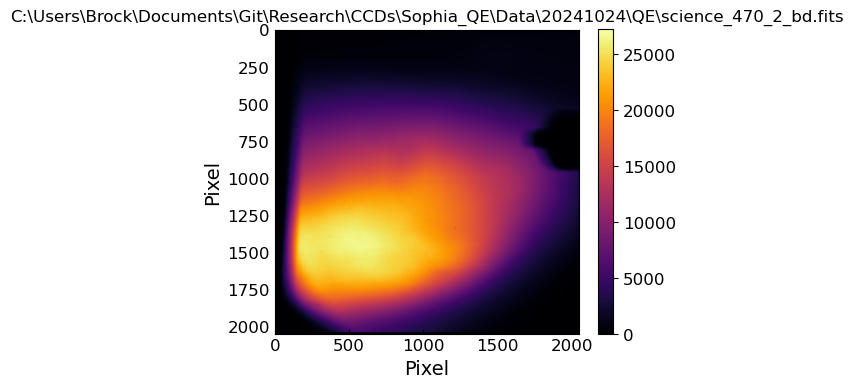

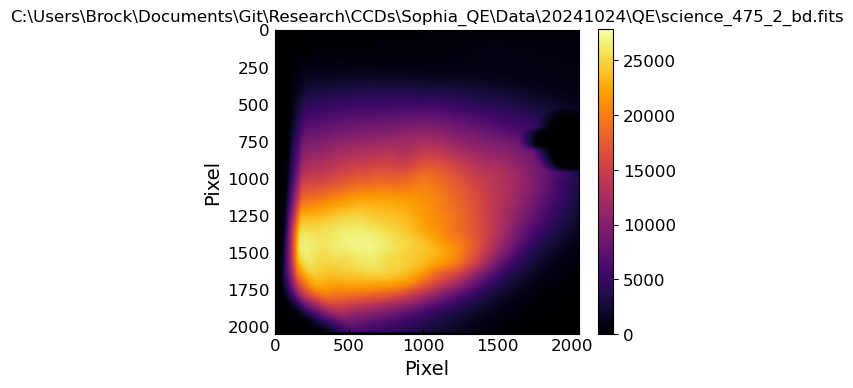

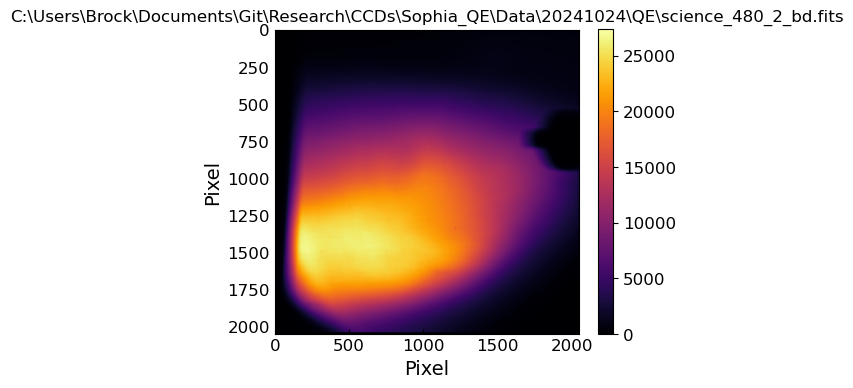

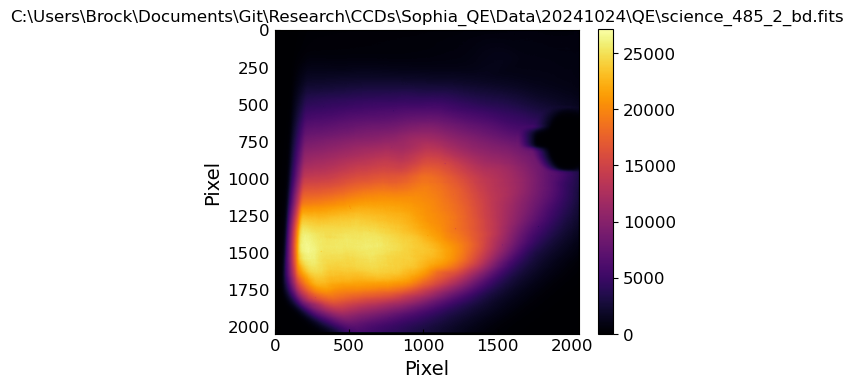

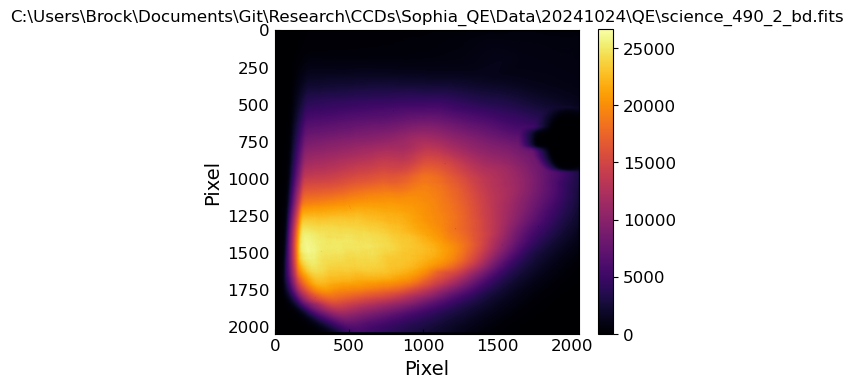

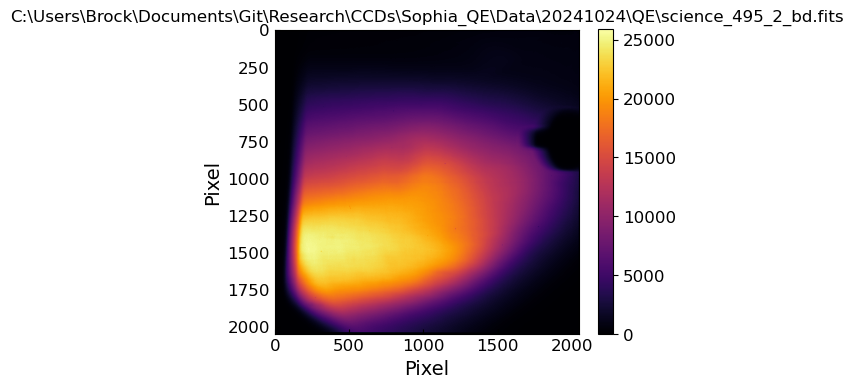

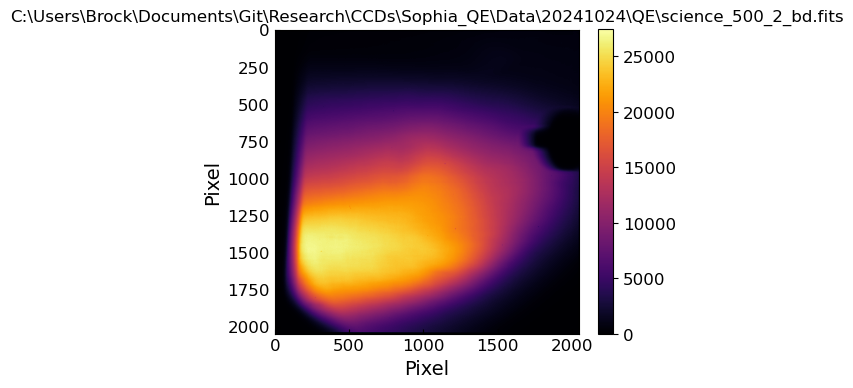

In [51]:
science_out_list = []

# BP Subtract master dark from all science images
for file in science_bias_subtracted_list:
    outfile = file.replace('_b.fits', '_bd.fits')
    
    hdul = fits.open(file)
    hdr = hdul[0].header
    data = hdul[0].data[0]
    
    data = data - master_dark # multipyl by exp time
    
    hdu = fits.PrimaryHDU(data = data, header = hdr)
    hdu.writeto(outfile, overwrite = True)
    
    science_out_list.append(outfile)
    
    hdul.close()

    title = outfile[-1:]

    fig, ax = plt.subplots(layout='tight', figsize=(5,4))
    cb = ax.imshow(data, cmap='inferno')
    ax.set_xlabel(r'Pixel')
    ax.set_ylabel(r'Pixel')
    ax.tick_params(axis='both', direction='in', which='both')
    plt.title(outfile)
    plt.colorbar(mappable=cb)
    fig.tight_layout()
    plt.show()

In [54]:
outfile[-10:-1]

'_2_bd.fit'